In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import weibull_min
import pandas as pd
# cargar datos simulados de tiempos de falla
datos = pd.read_csv("../data/failure-times.csv")
failure_times = datos['failure_time'].values
true_k = 2.5
true_lambda = 1000

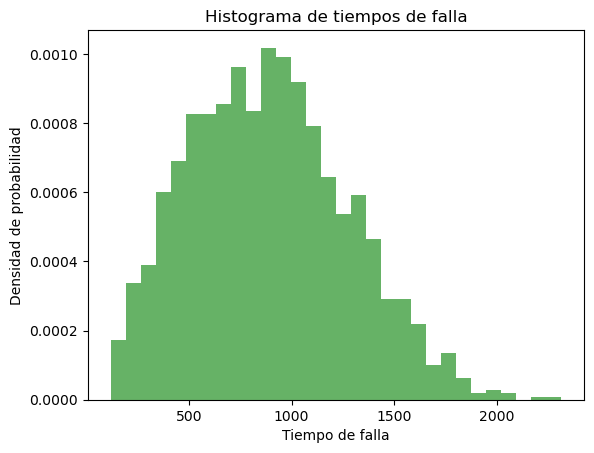

In [26]:
# visualizar los datos
plt.hist(failure_times, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Tiempo de falla')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma de tiempos de falla')
plt.show()

In [27]:
# --- 2. Definir la Negativa Log-Verosimilitud (NLL) ---

def negative_log_likelihood(params, data):
    """
    Calcula la negativa log-verosimilitud para una distribución de Weibull.
    params: una lista o array [k, lambda]
    data: los datos observados (tiempos de falla)
    """
    k, lam = params[0], params[1]

    # Restricciones: k y lambda deben ser positivos.
    # Si no lo son, devolvemos un valor muy grande para penalizar.
    if k <= 0 or lam <= 0:
        return np.inf

    # Cálculo de la log-verosimilitud
    # Se usan sumas de logaritmos para evitar underflow numérico
    log_likelihood = np.sum(
        np.log(k) - np.log(lam) + (k - 1) *
        (np.log(data) - np.log(lam)) - (data / lam)**k
    )

    # Devolvemos el negativo, porque el optimizador minimiza
    return -log_likelihood


In [28]:
# --- 3. Optimización para encontrar los parámetros ---
# conjetura inicial para los parámetros [k, lambda]
initial_guess = [2.0, 900.0]

# Límites para los parámetros (k>0, lambda>0) para ayudar al optimizador
bounds = ((1e-6, None), (1e-6, None))

# Usamos 'minimize' de scipy
# L-BFGS-B es un buen método que puede manejar límites (bounds)
result = minimize(
    fun=negative_log_likelihood,
    x0=initial_guess,
    args=(failure_times,),
    method='L-BFGS-B',
    bounds=bounds
)

# Extraemos los parámetros estimados
if result.success:
    estimated_k, estimated_lambda = result.x
    print(f"✅ Optimización exitosa.")
    print(f"   Parámetros verdaderos: k={true_k:.3f}, λ={true_lambda:.3f}")
    print(
        f"   Parámetros estimados (MLE): k={estimated_k:.3f}, λ={estimated_lambda:.3f}")
else:
    print(f"❌ La optimización falló: {result.message}")


✅ Optimización exitosa.
   Parámetros verdaderos: k=2.500, λ=1000.000
   Parámetros estimados (MLE): k=2.469, λ=1001.215


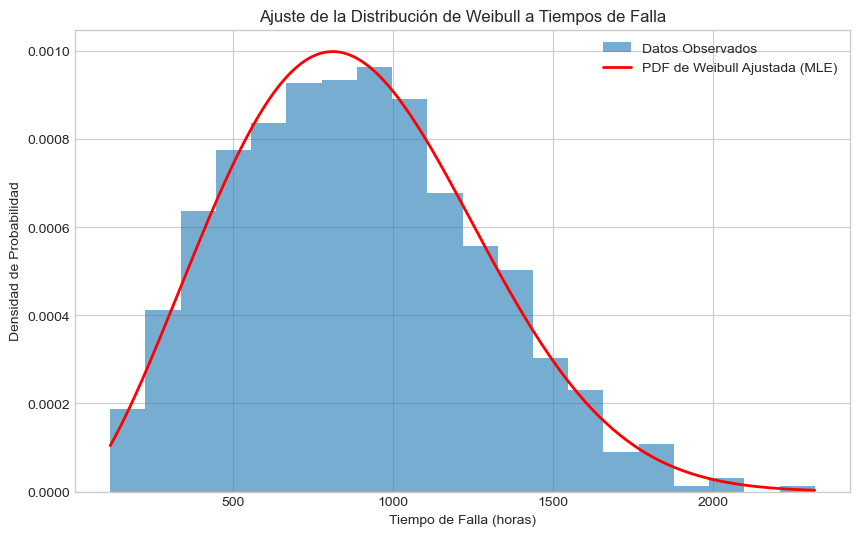


📈 Estimación a partir del modelo:
La vida media (mediana) estimada del componente es de 863.11 horas.
La probabilidad de falla antes de las 500 horas es de 16.5%.


In [29]:

# --- 4. Visualización y Uso del Modelo ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Histograma de los datos observados
ax.hist(failure_times, bins=20, density=True,
        alpha=0.6, label='Datos Observados')

# Curva PDF de la distribución de Weibull con los parámetros estimados
x_range = np.linspace(failure_times.min(), failure_times.max(), 200)
pdf_fitted = weibull_min.pdf(x_range, c=estimated_k, scale=estimated_lambda)
ax.plot(x_range, pdf_fitted, 'r-', lw=2, label='PDF de Weibull Ajustada (MLE)')

ax.set_title('Ajuste de la Distribución de Weibull a Tiempos de Falla')
ax.set_xlabel('Tiempo de Falla (horas)')
ax.set_ylabel('Densidad de Probabilidad')
ax.legend()
plt.show()

# --- 5. Hacer una Estimación Práctica ---
# ¿Cuál es la vida media (mediana) estimada de estos componentes?
# Usamos la función de punto porcentual (ppf), que es la inversa de la CDF.
median_lifetime = weibull_min.ppf(0.5, c=estimated_k, scale=estimated_lambda)
print(f"\n📈 Estimación a partir del modelo:")
print(
    f"La vida media (mediana) estimada del componente es de {median_lifetime:.2f} horas.")

# ¿Cuál es la probabilidad de que un componente falle antes de las 500 horas?
prob_fail_before_500 = weibull_min.cdf(
    500, c=estimated_k, scale=estimated_lambda)
print(
    f"La probabilidad de falla antes de las 500 horas es de {prob_fail_before_500:.1%}.")